 # TIME SERIES SALES FORCASTING - REGRESSION
 
## BUSINESS UNDERSTANDING 

### INTRODUCTION

Time series forecasting is one of the key topics of machine learning. The fact that so many prediction issues have a temporal component makes it crucial. In contrast to many other prediction tasks, time series issues are more challenging since the time component contributes more information.

#### TIME SERIES FORCASTING APPLICATION 
Time series forecasting is employed in various sectors, including finance, supply chain management, production, and inventory planning, making it one of the most widely used data science approaches. Time series forecasting has many applications, including resource allocation, business planning, weather forecasts, and stock price prediction.

Time series forecasting can be used by any business or organization dealing with continuously generated data and the requirement to adjust to operational shifts and changes. Here, machine learning acts as the greatest enabler, improving our ability to:

#### Web traffic forecasting: 
In order to forecast online traffic rates during certain periods, common data on typical traffic rates among competing websites is combined with input data on traffic-related trends.

#### Sales and demand forecasting: 
Customer behavior pattern data, in combination with inputs from purchase history, demand history, seasonal influence, etc., enables machine learning models to identify the most demanded items and pinpoint their placement in the dynamic market.

#### Weather prediction: 
Time-based data is routinely collected from a variety of globally networked weather stations, and machine learning approaches enable in-depth analysis and interpretation of the data for future forecasts based on statistical dynamics.

#### Stock price forecasting: 
In order to make accurate forecasts of the most likely impending stock price movements, one can integrate historical stock price data with information on regular and atypical spikes and decreases in the stock market.

#### Economic and demographic forecasting: 
Demographics and economics have a ton of statistical data that can be utilized to forecast time series data effectively. Consequently, the ideal target market can be determined, and the most effective strategies to communicate with that specific TA may be developed.

#### Academics: 
The concepts of machine learning and deep learning greatly speed up the processes of refining and launching scientific ideas. For instance, scientific data that must go through infinite analytical cycles may be analyzed considerably more quickly with machine learning patterns.

### PROJECT OBJECTIVE
In this project, we'll predict store sales on data from Corporation Favorita, a large Ecuadorian-based grocery retailer.

We shall also build a model that will accurately predicts the unit sales for thousands of items sold at different Favorita stores.

### HYPOTHESIS STATEMENT
Null Hypothesis:Sales are not affected by promotions, oil prices and holidays. 

Alternate Hypothesis: Sales are affected by promotions, oil prices and holidays

### ANALYTICAL QUESTIONS

1) Is the train dataset complete (has all the required dates)?

2) Which dates have the lowest and highest sales for each year?

3) Did the earthquake impact sales?

4) Are certain groups of stores selling more products? (Cluster, city, state, type)

5) Are sales affected by promotions, oil prices and holidays?

6) What analysis can we get from the date and its extractable features?

7) What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)


## IMPORTING RELEVANT LIBRARIES

In [96]:
#! pip install --upgrade category_encoders
#! pip install pmdarima

import pandas as pd
import numpy as np
import pyodbc    
from dotenv import dotenv_values

import statsmodels.api as sm

##Visualization Libraries 
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns 
import random
import plotly.offline as offline
offline.init_notebook_mode(connected=True) # Configure Plotly to run offline


# Feature Processing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Algorithms libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
import xgboost


##pipelines and transformers 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.pipeline import make_pipeline
import category_encoders as ce

##handling imbalance datasets
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

##hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

##for hypothesis testing 
from scipy.stats import chi2_contingency

##model evaluation:
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
# Other packages
import os
from itertools import product
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# DATA UNDERSTANDING


## LOADING ALL DATASETS

Firstly, we shall fetch some datasets from sql server using the method below:

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [3]:
# Use the connect method of the pyodbc library and pass in the connection string.
#This will connect to the server
connection = pyodbc.connect(connection_string)

In [4]:
# Now the sql query to get the 1st data 
query = "Select * from dbo.oil"
oil = pd.read_sql(query,connection)

#oil.to_csv('oil.csv')  

oil

date  dcoilwtico
0     2013-01-01         NaN
1     2013-01-02   93.139999
2     2013-01-03   92.970001
3     2013-01-04   93.120003
4     2013-01-07   93.199997
...          ...         ...
1213  2017-08-25   47.650002
1214  2017-08-28   46.400002
1215  2017-08-29   46.459999
1216  2017-08-30   45.959999
1217  2017-08-31   47.259998

[1218 rows x 2 columns]

In [5]:
# Now the sql query to get the 2nd data 
query = "Select * from dbo.holidays_events"
holidays = pd.read_sql(query,connection)

#holidays.to_csv('holidays.csv')  

holidays

date        type    locale locale_name  \
0    2012-03-02     Holiday     Local       Manta   
1    2012-04-01     Holiday  Regional    Cotopaxi   
2    2012-04-12     Holiday     Local      Cuenca   
3    2012-04-14     Holiday     Local    Libertad   
4    2012-04-21     Holiday     Local    Riobamba   
..          ...         ...       ...         ...   
345  2017-12-22  Additional  National     Ecuador   
346  2017-12-23  Additional  National     Ecuador   
347  2017-12-24  Additional  National     Ecuador   
348  2017-12-25     Holiday  National     Ecuador   
349  2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

In [6]:
# Now the sql query to get the 3rd data 
query = "Select * from dbo.stores"
stores = pd.read_sql(query,connection)

#stores.to_csv('stores.csv')  

stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [7]:
sample_submission = pd.read_csv("sample_submission.csv")

sample_submission

id  sales
0      3000888    0.0
1      3000889    0.0
2      3000890    0.0
3      3000891    0.0
4      3000892    0.0
...        ...    ...
28507  3029395    0.0
28508  3029396    0.0
28509  3029397    0.0
28510  3029398    0.0
28511  3029399    0.0

[28512 rows x 2 columns]

In [8]:
test = pd.read_csv("test.csv")

test

id        date  store_nbr                      family  onpromotion
0      3000888  2017-08-16          1                  AUTOMOTIVE            0
1      3000889  2017-08-16          1                   BABY CARE            0
2      3000890  2017-08-16          1                      BEAUTY            2
3      3000891  2017-08-16          1                   BEVERAGES           20
4      3000892  2017-08-16          1                       BOOKS            0
...        ...         ...        ...                         ...          ...
28507  3029395  2017-08-31          9                     POULTRY            1
28508  3029396  2017-08-31          9              PREPARED FOODS            0
28509  3029397  2017-08-31          9                     PRODUCE            1
28510  3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399  2017-08-31          9                     SEAFOOD            0

[28512 rows x 5 columns]

In [9]:
transactions = pd.read_csv("transactions.csv")

transactions

date  store_nbr  transactions
0      2013-01-01         25           770
1      2013-01-02          1          2111
2      2013-01-02          2          2358
3      2013-01-02          3          3487
4      2013-01-02          4          1922
...           ...        ...           ...
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802

[83488 rows x 3 columns]

In [10]:
train = pd.read_excel("train.xlsx")

train

id       date  store_nbr                      family    sales  \
0              0 2013-01-01          1                  AUTOMOTIVE    0.000   
1              1 2013-01-01          1                   BABY CARE    0.000   
2              2 2013-01-01          1                      BEAUTY    0.000   
3              3 2013-01-01          1                   BEVERAGES    0.000   
4              4 2013-01-01          1                       BOOKS    0.000   
...          ...        ...        ...                         ...      ...   
1048570  1048570 2014-08-13          3                     POULTRY  974.098   
1048571  1048571 2014-08-13          3              PREPARED FOODS  324.293   
1048572  1048572 2014-08-13          3                     PRODUCE   10.000   
1048573  1048573 2014-08-13          3  SCHOOL AND OFFICE SUPPLIES    0.000   
1048574  1048574 2014-08-13          3                     SEAFOOD   69.116   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
1048570            1  
1048571            0  
1048572            1  
1048573            0  
1048574            0  

[1048575 rows x 6 columns]

## Exploratory Data Analysis (EDA)

In [11]:
oil.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02   93.139999
2  2013-01-03   92.970001
3  2013-01-04   93.120003
4  2013-01-07   93.199997

In [12]:
holidays.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [13]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [14]:
sample_submission.head()

id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0

In [15]:
test.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [16]:
transactions.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [17]:
train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [18]:
# creating a list of the datasets

list_datasets = [stores, train, test, transactions, oil, holidays, sample_submission]

In [19]:
# creating a function that will Check for the info on all the datasets

def general_info(datasets):
    for data in datasets:
        variable_name  = globals()
        print(data.info())
#         print('\n')
        print('_' * 50)

In [20]:
general_info(list_datasets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           1048575 non-null  int64         
 1   date         1048575 non-null  datetime64[ns]
 2   store_nbr    1048575 non-null  int64         
 3   family       1048575 non-null  object        
 4   sales        1048575 non-null  float64       
 5   onpromotion  1048575 non-null  int64         

In [21]:
# creating a function that will Check for the missing values on all the datasets

def show_missing_val(datasets):
    for data in datasets:
        print(data.isnull().sum())
        print('_' * 50)

In [22]:
show_missing_val(list_datasets)

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
__________________________________________________
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
__________________________________________________
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
__________________________________________________
date            0
store_nbr       0
transactions    0
dtype: int64
__________________________________________________
date           0
dcoilwtico    43
dtype: int64
__________________________________________________
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
__________________________________________________
id       0
sales    0
dtype: int64
__________________________________________________


Only the oil dataset has missing values.

### FILLING THE MISSING VALUES ON THE OIL DATASET

In [23]:
# FILLING THAT MISSING DATA ON OIL DATASET USING SIMPLEIMPUTER WITH MEAN STRATEGY

imputer = SimpleImputer(strategy='mean')

# fitting the imputer to the 'dcoilwtico' column of the oil dataset

imputer.fit(oil[['dcoilwtico']])



SimpleImputer()

In [24]:
# Impute the missing values on the 'dcoilwtco' column
oil['dcoilwtico'] = imputer.transform(oil[['dcoilwtico']])



In [25]:
oil.head()

date  dcoilwtico
0  2013-01-01   67.714366
1  2013-01-02   93.139999
2  2013-01-03   92.970001
3  2013-01-04   93.120003
4  2013-01-07   93.199997

In [26]:
oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [27]:
# CONVERTING ALL THE DATASET 'DATE COLUMNS' TO DATE TIME

train['date'] = pd.to_datetime(train['date'])

oil['date'] = pd.to_datetime(oil['date'])

holidays['date'] = pd.to_datetime(holidays['date'])

transactions['date'] = pd.to_datetime(transactions['date'])


## COMBINING ALL THE DATASETS BASED ON COMMON COLUMNS

In [28]:
# Merging the Transaction dataset to the Train on 'date' and 'store_nbr' columns

data = pd.merge(train, transactions, on = ['date', 'store_nbr'], how='left')

# Merging the holidays dataset to df on 'date' column

data2 = pd.merge(data, holidays, on = 'date', how='left')

# Merging oil dataset to df2 on 'date' column

data3 = pd.merge(data2, oil, on = 'date', how='left')


# Merging the store dataset to df3 on 'store_nbr' column

train_data = pd.merge(data3, stores, on = 'store_nbr', how='left')



In [29]:
train_data

id       date  store_nbr                      family    sales  \
0              0 2013-01-01          1                  AUTOMOTIVE    0.000   
1              1 2013-01-01          1                   BABY CARE    0.000   
2              2 2013-01-01          1                      BEAUTY    0.000   
3              3 2013-01-01          1                   BEVERAGES    0.000   
4              4 2013-01-01          1                       BOOKS    0.000   
...          ...        ...        ...                         ...      ...   
1064608  1048570 2014-08-13          3                     POULTRY  974.098   
1064609  1048571 2014-08-13          3              PREPARED FOODS  324.293   
1064610  1048572 2014-08-13          3                     PRODUCE   10.000   
1064611  1048573 2014-08-13          3  SCHOOL AND OFFICE SUPPLIES    0.000   
1064612  1048574 2014-08-13          3                     SEAFOOD   69.116   

         onpromotion  transactions   type_x    locale locale_name  \
0                  0           NaN  Holiday  National     Ecuador   
1                  0           NaN  Holiday  National     Ecuador   
2                  0           NaN  Holiday  National     Ecuador   
3                  0           NaN  Holiday  National     Ecuador   
4                  0           NaN  Holiday  National     Ecuador   
...              ...           ...      ...       ...         ...   
1064608            1        2991.0      NaN       NaN         NaN   
1064609            0        2991.0      NaN       NaN         NaN   
1064610            1        2991.0      NaN       NaN         NaN   
1064611            0        2991.0      NaN       NaN         NaN   
1064612            0        2991.0      NaN       NaN         NaN   

                description transferred  dcoilwtico   city      state type_y  \
0        Primer dia del ano       False   67.714366  Quito  Pichincha      D   
1        Primer dia del ano       False   67.714366  Quito  Pichincha      D   
2        Primer dia del ano       False   67.714366  Quito  Pichincha      D   
3        Primer dia del ano       False   67.714366  Quito  Pichincha      D   
4        Primer dia del ano       False   67.714366  Quito  Pichincha      D   
...                     ...         ...         ...    ...        ...    ...   
1064608                 NaN         NaN   97.570000  Quito  Pichincha      D   
1064609                 NaN         NaN   97.570000  Quito  Pichincha      D   
1064610                 NaN         NaN   97.570000  Quito  Pichincha      D   
1064611                 NaN         NaN   97.570000  Quito  Pichincha      D   
1064612                 NaN         NaN   97.570000  Quito  Pichincha      D   

         cluster  
0             13  
1             13  
2             13  
3             13  
4             13  
...          ...  
1064608        8  
1064609        8  
1064610        8  
1064611        8  
1064612        8  

[1064613 rows x 17 columns]

In [30]:
# Analysing 'type_x' column on the train_data

train_data['type_x'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer'],
      dtype=object)

In [31]:
# Analysing 'type_y' column on the train_data

train_data['type_y'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [32]:
# Renaming 'type_x' to holidays_type, 'type_y' to store_type and 'dcoilwtico' to oil_price

train_data = train_data.rename(columns = {'type_x': 'holidays_type', 'type_y': 'store_type', 'dcoilwtico': 'oil_prices'})


In [33]:
train_data

id       date  store_nbr                      family    sales  \
0              0 2013-01-01          1                  AUTOMOTIVE    0.000   
1              1 2013-01-01          1                   BABY CARE    0.000   
2              2 2013-01-01          1                      BEAUTY    0.000   
3              3 2013-01-01          1                   BEVERAGES    0.000   
4              4 2013-01-01          1                       BOOKS    0.000   
...          ...        ...        ...                         ...      ...   
1064608  1048570 2014-08-13          3                     POULTRY  974.098   
1064609  1048571 2014-08-13          3              PREPARED FOODS  324.293   
1064610  1048572 2014-08-13          3                     PRODUCE   10.000   
1064611  1048573 2014-08-13          3  SCHOOL AND OFFICE SUPPLIES    0.000   
1064612  1048574 2014-08-13          3                     SEAFOOD   69.116   

         onpromotion  transactions holidays_type    locale locale_name  \
0                  0           NaN       Holiday  National     Ecuador   
1                  0           NaN       Holiday  National     Ecuador   
2                  0           NaN       Holiday  National     Ecuador   
3                  0           NaN       Holiday  National     Ecuador   
4                  0           NaN       Holiday  National     Ecuador   
...              ...           ...           ...       ...         ...   
1064608            1        2991.0           NaN       NaN         NaN   
1064609            0        2991.0           NaN       NaN         NaN   
1064610            1        2991.0           NaN       NaN         NaN   
1064611            0        2991.0           NaN       NaN         NaN   
1064612            0        2991.0           NaN       NaN         NaN   

                description transferred  oil_prices   city      state  \
0        Primer dia del ano       False   67.714366  Quito  Pichincha   
1        Primer dia del ano       False   67.714366  Quito  Pichincha   
2        Primer dia del ano       False   67.714366  Quito  Pichincha   
3        Primer dia del ano       False   67.714366  Quito  Pichincha   
4        Primer dia del ano       False   67.714366  Quito  Pichincha   
...                     ...         ...         ...    ...        ...   
1064608                 NaN         NaN   97.570000  Quito  Pichincha   
1064609                 NaN         NaN   97.570000  Quito  Pichincha   
1064610                 NaN         NaN   97.570000  Quito  Pichincha   
1064611                 NaN         NaN   97.570000  Quito  Pichincha   
1064612                 NaN         NaN   97.570000  Quito  Pichincha   

        store_type  cluster  
0                D       13  
1                D       13  
2                D       13  
3                D       13  
4                D       13  
...            ...      ...  
1064608          D        8  
1064609          D        8  
1064610          D        8  
1064611          D        8  
1064612          D        8  

[1064613 rows x 17 columns]

## NEW FEATURES CREATION

In [34]:
# Setting the data column to be index

train_data = train_data.set_index('date')

In [35]:
# Splitting the date to create year, month, week, days of the month and days of the year columns

train_data['Year'] = train_data.index.year
train_data['Month'] = train_data.index.month
train_data['DayOfMonth'] = train_data.index.day
train_data['DaysInMonth'] = train_data.index.days_in_month
train_data['DayOfYear'] = train_data.index.day_of_year
train_data['Week'] = train_data.index.weekofyear

In [36]:
train_data

id  store_nbr                      family    sales  \
date                                                                  
2013-01-01        0          1                  AUTOMOTIVE    0.000   
2013-01-01        1          1                   BABY CARE    0.000   
2013-01-01        2          1                      BEAUTY    0.000   
2013-01-01        3          1                   BEVERAGES    0.000   
2013-01-01        4          1                       BOOKS    0.000   
...             ...        ...                         ...      ...   
2014-08-13  1048570          3                     POULTRY  974.098   
2014-08-13  1048571          3              PREPARED FOODS  324.293   
2014-08-13  1048572          3                     PRODUCE   10.000   
2014-08-13  1048573          3  SCHOOL AND OFFICE SUPPLIES    0.000   
2014-08-13  1048574          3                     SEAFOOD   69.116   

            onpromotion  transactions holidays_type    locale locale_name  \
date                                                                        
2013-01-01            0           NaN       Holiday  National     Ecuador   
2013-01-01            0           NaN       Holiday  National     Ecuador   
2013-01-01            0           NaN       Holiday  National     Ecuador   
2013-01-01            0           NaN       Holiday  National     Ecuador   
2013-01-01            0           NaN       Holiday  National     Ecuador   
...                 ...           ...           ...       ...         ...   
2014-08-13            1        2991.0           NaN       NaN         NaN   
2014-08-13            0        2991.0           NaN       NaN         NaN   
2014-08-13            1        2991.0           NaN       NaN         NaN   
2014-08-13            0        2991.0           NaN       NaN         NaN   
2014-08-13            0        2991.0           NaN       NaN         NaN   

                   description  ...   city      state store_type cluster  \
date                            ...                                        
2013-01-01  Primer dia del ano  ...  Quito  Pichincha          D      13   
2013-01-01  Primer dia del ano  ...  Quito  Pichincha          D      13   
2013-01-01  Primer dia del ano  ...  Quito  Pichincha          D      13   
2013-01-01  Primer dia del ano  ...  Quito  Pichincha          D      13   
2013-01-01  Primer dia del ano  ...  Quito  Pichincha          D      13   
...                        ...  ...    ...        ...        ...     ...   
2014-08-13                 NaN  ...  Quito  Pichincha          D       8   
2014-08-13                 NaN  ...  Quito  Pichincha          D       8   
2014-08-13                 NaN  ...  Quito  Pichincha          D       8   
2014-08-13                 NaN  ...  Quito  Pichincha          D       8   
2014-08-13                 NaN  ...  Quito  Pichincha          D       8   

            Year  Month  DayOfMonth  DaysInMonth  DayOfYear  Week  
date                                                               
2013-01-01  2013      1           1           31          1     1  
2013-01-01  2013      1           1           31          1     1  
2013-01-01  2013      1           1           31          1     1  
2013-01-01  2013      1           1           31          1     1  
2013-01-01  2013      1           1           31          1     1  
...          ...    ...         ...          ...        ...   ...  
2014-08-13  2014      8          13           31        225    33  
2014-08-13  2014      8          13           31        225    33  
2014-08-13  2014      8          13           31        225    33  
2014-08-13  2014      8          13           31        225    33  
2014-08-13  2014      8          13           31        225    33  

[1064613 rows x 22 columns]

In [37]:
train_data.shape

(1064613, 22)

In [38]:
train_data.describe()

id     store_nbr         sales   onpromotion   transactions  \
count  1.064613e+06  1.064613e+06  1.064613e+06  1.064613e+06  917268.000000   
mean   5.258965e+05  2.749267e+01  2.443419e+02  1.162704e-01    1722.149122   
std    3.031815e+05  1.558411e+01  8.058784e+02  2.371496e+00     956.928549   
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00     203.000000   
25%    2.643710e+05  1.400000e+01  0.000000e+00  0.000000e+00    1077.000000   
50%    5.251780e+05  2.700000e+01  1.000000e+00  0.000000e+00    1416.000000   
75%    7.895490e+05  4.100000e+01  1.200000e+02  0.000000e+00    2175.250000   
max    1.048574e+06  5.400000e+01  4.627100e+04  1.960000e+02    8256.000000   

          oil_prices       cluster          Year         Month    DayOfMonth  \
count  761673.000000  1.064613e+06  1.064613e+06  1.064613e+06  1.064613e+06   
mean       98.237884  8.482068e+00  2.013382e+03  5.661635e+00  1.553588e+01   
std         7.549066  4.649914e+00  4.859617e-01  3.197558e+00  8.813354e+00   
min        67.714366  1.000000e+00  2.013000e+03  1.000000e+00  1.000000e+00   
25%        94.550003  4.000000e+00  2.013000e+03  3.000000e+00  8.000000e+00   
50%        98.290001  9.000000e+00  2.013000e+03  5.000000e+00  1.500000e+01   
75%       103.400002  1.300000e+01  2.014000e+03  8.000000e+00  2.300000e+01   
max       110.620003  1.700000e+01  2.014000e+03  1.200000e+01  3.100000e+01   

        DaysInMonth     DayOfYear          Week  
count  1.064613e+06  1.064613e+06  1.064613e+06  
mean   3.040913e+01  1.564509e+02  2.280292e+01  
std    8.967478e-01  9.753729e+01  1.386098e+01  
min    2.800000e+01  1.000000e+00  1.000000e+00  
25%    3.000000e+01  7.500000e+01  1.100000e+01  
50%    3.100000e+01  1.490000e+02  2.200000e+01  
75%    3.100000e+01  2.210000e+02  3.200000e+01  
max    3.100000e+01  3.650000e+02  5.200000e+01

In [84]:
train_data.tail()

id  store_nbr                      family    sales  \
date                                                                  
2014-08-13  1048570          3                     POULTRY  974.098   
2014-08-13  1048571          3              PREPARED FOODS  324.293   
2014-08-13  1048572          3                     PRODUCE   10.000   
2014-08-13  1048573          3  SCHOOL AND OFFICE SUPPLIES    0.000   
2014-08-13  1048574          3                     SEAFOOD   69.116   

            onpromotion  transactions holidays_type locale locale_name  \
date                                                                     
2014-08-13            1        2991.0           NaN    NaN         NaN   
2014-08-13            0        2991.0           NaN    NaN         NaN   
2014-08-13            1        2991.0           NaN    NaN         NaN   
2014-08-13            0        2991.0           NaN    NaN         NaN   
2014-08-13            0        2991.0           NaN    NaN         NaN   

           description  ...   city      state store_type cluster  Year  Month  \
date                    ...                                                     
2014-08-13         NaN  ...  Quito  Pichincha          D       8  2014      8   
2014-08-13         NaN  ...  Quito  Pichincha          D       8  2014      8   
2014-08-13         NaN  ...  Quito  Pichincha          D       8  2014      8   
2014-08-13         NaN  ...  Quito  Pichincha          D       8  2014      8   
2014-08-13         NaN  ...  Quito  Pichincha          D       8  2014      8   

            DayOfMonth  DaysInMonth  DayOfYear  Week  
date                                                  
2014-08-13          13           31        225    33  
2014-08-13          13           31        225    33  
2014-08-13          13           31        225    33  
2014-08-13          13           31        225    33  
2014-08-13          13           31        225    33  

[5 rows x 22 columns]

## UNIVARIATE ANALYSIS

<AxesSubplot:xlabel='date'>

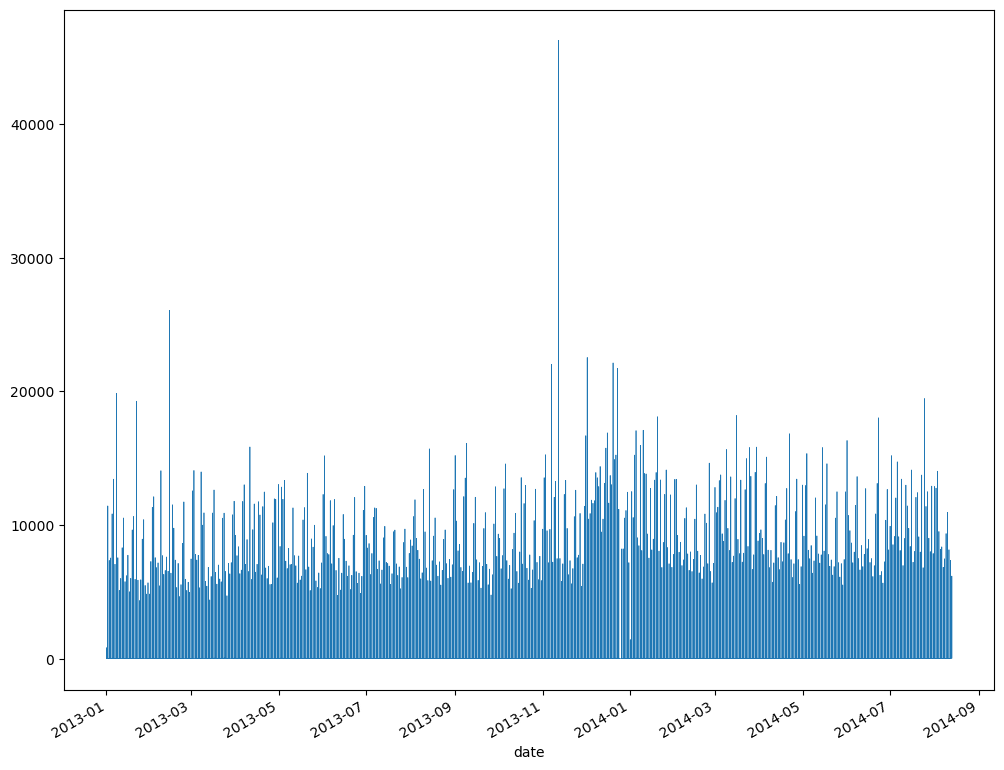

In [43]:
# Analysing the date column

plt.figure(figsize = (12,10))
train_data['sales'].plot(linewidth = 0.5)

<Figure size 1200x1000 with 0 Axes>

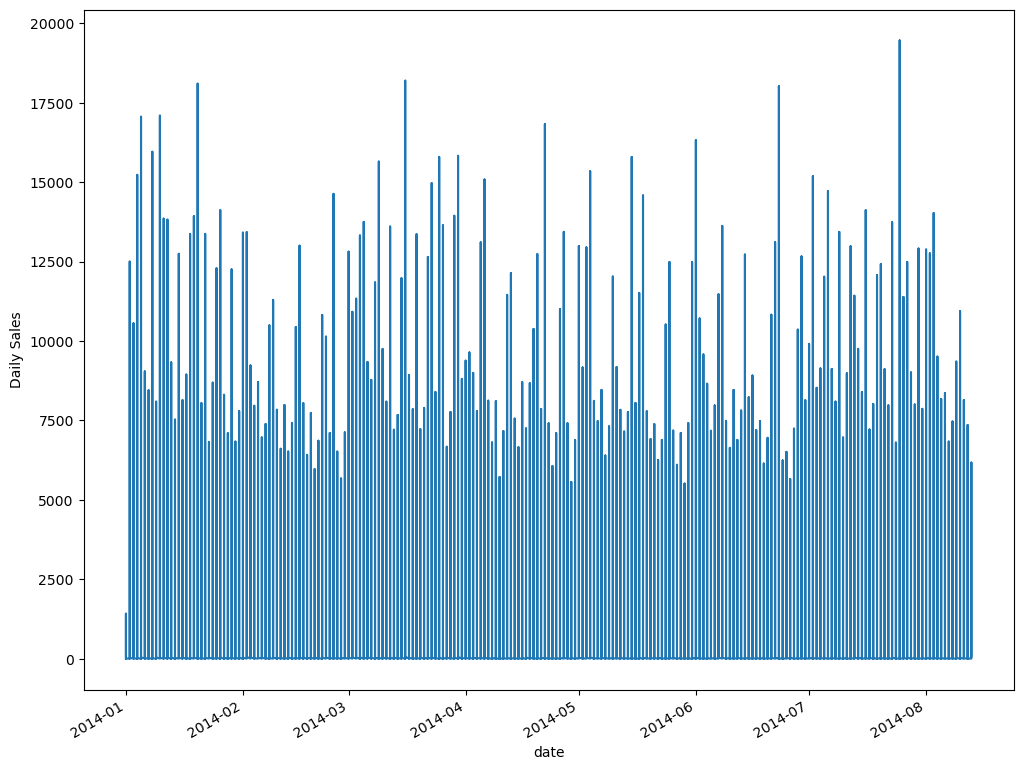

<Figure size 1200x1000 with 0 Axes>

In [44]:
# Plot on 2014 year

plt.figure(figsize = (12,10))
ax = train_data.loc['2014', 'sales'].plot()
ax.set_ylabel('Daily Sales');
plt.figure(figsize = (12,10))

<AxesSubplot:xlabel='date'>

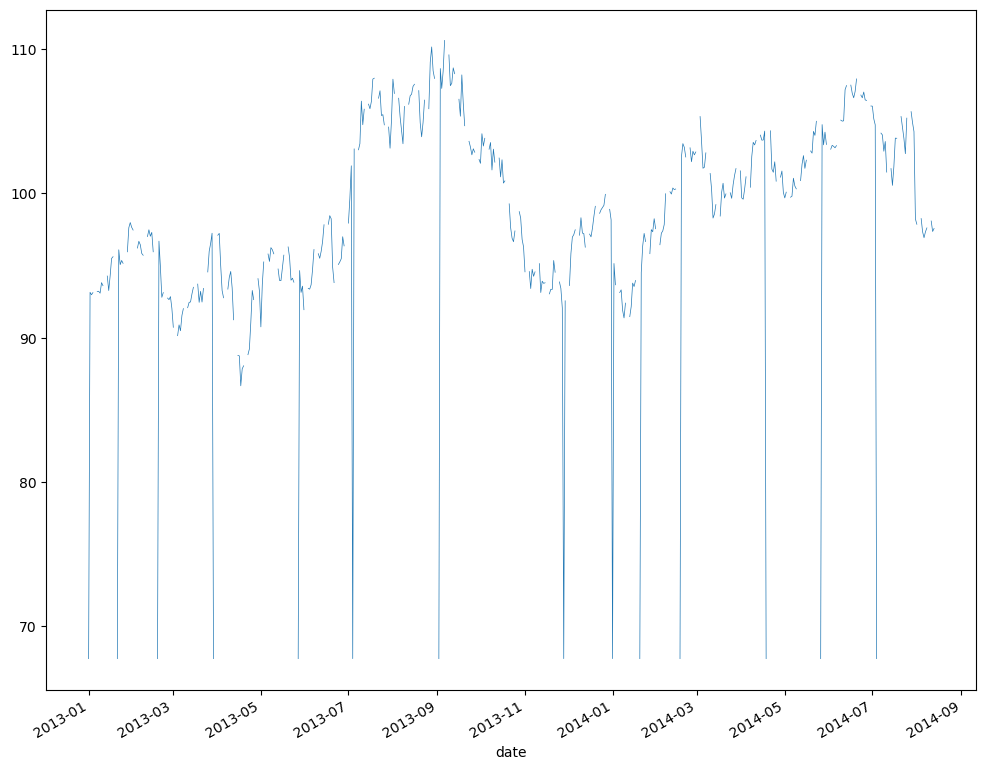

In [45]:
plt.figure(figsize = (12,10))
train_data['oil_prices'].plot(linewidth = 0.5)

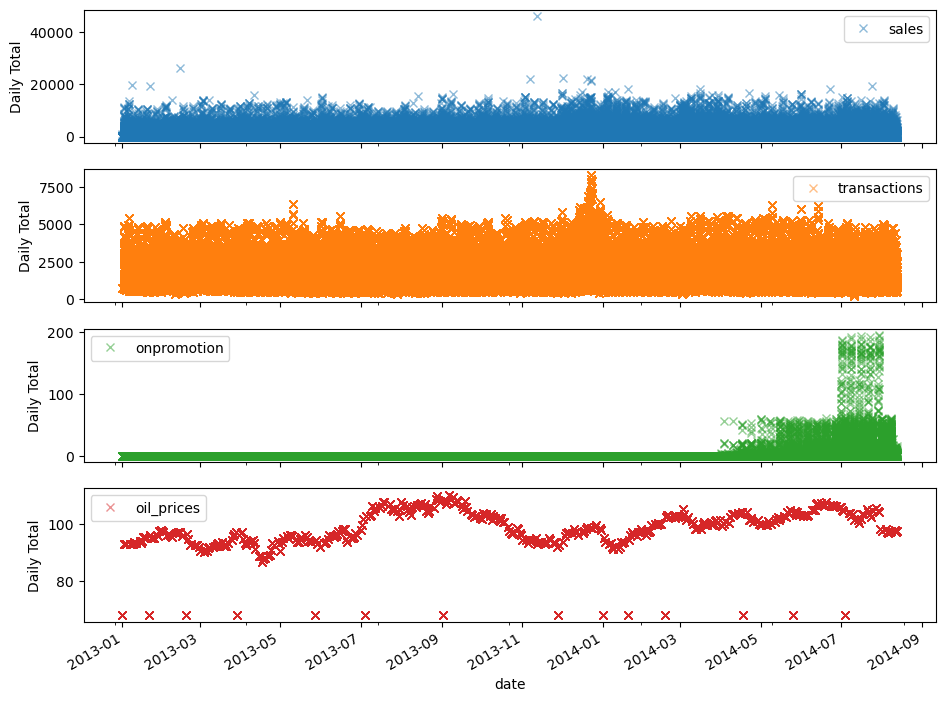

In [46]:
cols_plot = ['sales', 'transactions', 'onpromotion', 'oil_prices']
axes = train_data[cols_plot].plot(marker ='x', alpha = 0.5, linestyle = 'None', figsize = (11,9), subplots = True)
for ax in axes:
    ax.set_ylabel('Daily Total')
#plt.figure(figsize = (12,10))
#train_data['onpromotion'].plot(linewidth = 0.5)

From the graphs abocve we can deduce the following informations:

1) There is seasonality in the dataset

2) There is also trends in the dataset.

3) There is cyclical variation

4) Oil Price is low in the begining of the year and goes up in in February of each year.

5) Sales and transaction are high in the last month of the year during christmax celebration

## BIVARIATE ANALYSIS

Text(0.5, 1.0, 'RELATION BETWEEN SALES AND ONPROMOTION')

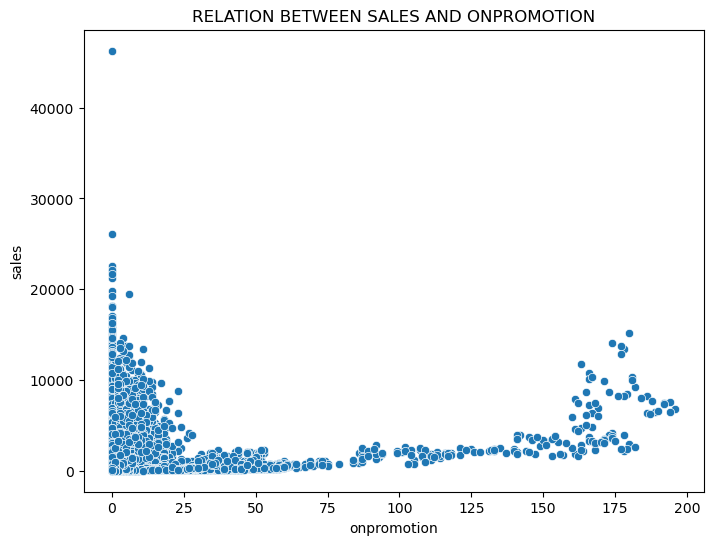

In [157]:
# RELATIONSHIP BETWEEN SALES AND ONPROMOTION

plt.figure(figsize=(8,6))
sns.scatterplot(train_data['onpromotion'], train_data['sales'])
plt.title('RELATION BETWEEN SALES AND ONPROMOTION')

In [159]:
# Which family has the highest sales ( Family vs Sales)

family_with_highest_sales = train_data.groupby('family')['sales'].sum().reset_index()
#plt.figure(figsize = (8,6))
#sns.barplot(data=family_with_highest_sales, x='family', y='sales')

In [160]:
# Sorting the Family with highest Sales

family_sales = family_with_highest_sales.sort_values(by=['sales'], ascending=False)

In [161]:
# Top ten family with the highest sales

family_sales.head(10)

family        sales
12      GROCERY I 98159401.882
3       BEVERAGES 44177125.000
7        CLEANING 29498505.000
8           DAIRY 16125958.000
5    BREAD/BAKERY 11852504.156
24          MEATS 10484703.059
30        PRODUCE 10007090.414
28        POULTRY  9026394.242
9            DELI  6770108.330
25  PERSONAL CARE  6721624.000

<AxesSubplot:xlabel='family', ylabel='sales'>

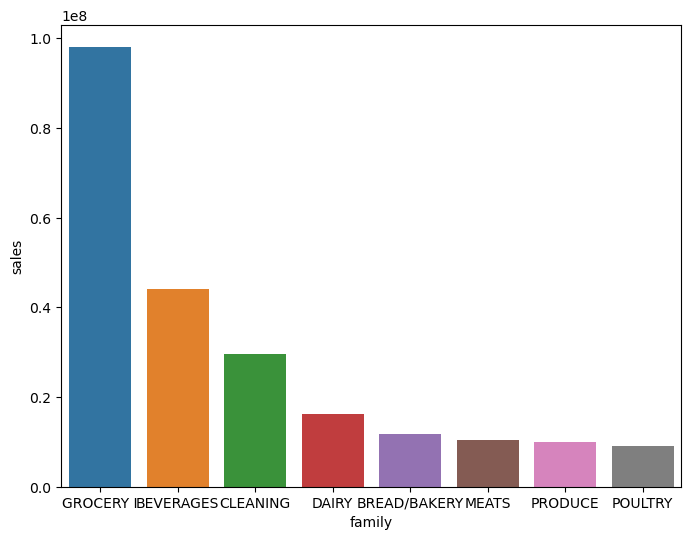

In [163]:
# Visiualizing the top 8 family with the highest sales
plt.figure(figsize = (8,6))
sns.barplot(data=family_sales.head(8), x='family', y='sales')

## MULTIVARIATE ANALYSIS

WE SHALL USE RESAMPLING TO A LOWER FREQUENCY (DOWNSAMPLING) TO DO THE MULTIVARIATE ANALYSIS.

In [48]:
# SPECIFY THE COLUMNS TO INCLUDE

data_columns = ['sales', 'transactions', 'onpromotion', 'oil_prices']

# Resample to weekly frequency, aggregating with mean

data_weekly_mean = train_data[data_columns].resample('w').mean()

data_weekly_mean.head()

sales  transactions  onpromotion  oil_prices
date                                                         
2013-01-06  206.843478   1883.203463          0.0   86.736092
2013-01-13  190.285220   1641.090062          0.0   93.379999
2013-01-20  189.835452   1639.024845          0.0   94.581999
2013-01-27  182.152050   1609.816770          0.0   89.872872
2013-02-03  198.564267   1685.263975          0.0   97.332001

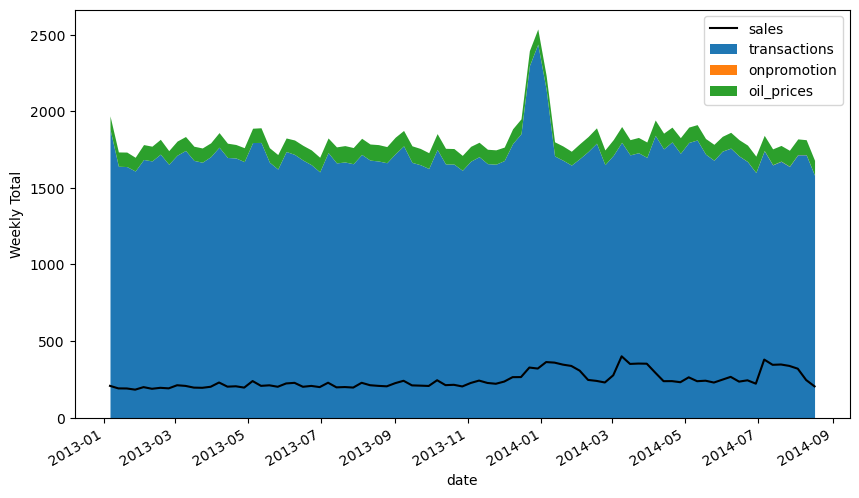

In [49]:
# Visualising the data_weekly_mean calculated above

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(data_weekly_mean['sales'], color='black', label = 'sales')
data_weekly_mean[['transactions', 'onpromotion', 'oil_prices']].plot.area(ax=ax, linewidth=0)
#ax.xaxis.set_major_locator(YearLocator())
ax.legend()
ax.set_ylabel('Weekly Total');

from the above, the series is not stationary.

## CHECKING THE CORRELATION

In [50]:
train_data.corr()

id  store_nbr     sales  onpromotion  transactions  \
id            1.000000   0.000050  0.043980     0.073746      0.017791   
store_nbr     0.000050   1.000000  0.029457    -0.003826      0.185880   
sales         0.043980   0.029457  1.000000     0.089245      0.206597   
onpromotion   0.073746  -0.003826  0.089245     1.000000      0.004254   
transactions  0.017791   0.185880  0.206597     0.004254      1.000000   
oil_prices    0.351186   0.000058  0.011337     0.025814      0.000446   
cluster       0.000092  -0.059487  0.043177     0.001458      0.201751   
Year          0.842769  -0.000598  0.043607     0.062314     -0.000982   
Month         0.215955  -0.000344 -0.001335     0.016079      0.034648   
DayOfMonth    0.021262   0.000135 -0.013118    -0.002167     -0.031163   
DaysInMonth   0.095015  -0.000310  0.018094     0.021485      0.012233   
DayOfYear     0.215936  -0.000331 -0.002595     0.015593      0.031749   
Week          0.216335  -0.000346 -0.004412     0.016617      0.019315   

              oil_prices   cluster      Year     Month  DayOfMonth  \
id              0.351186  0.000092  0.842769  0.215955    0.021262   
store_nbr       0.000058 -0.059487 -0.000598 -0.000344    0.000135   
sales           0.011337  0.043177  0.043607 -0.001335   -0.013118   
onpromotion     0.025814  0.001458  0.062314  0.016079   -0.002167   
transactions    0.000446  0.201751 -0.000982  0.034648   -0.031163   
oil_prices      1.000000 -0.000016  0.198000  0.253729    0.042790   
cluster        -0.000016  1.000000  0.000160  0.000092   -0.000036   
Year            0.198000  0.000160  1.000000 -0.341318   -0.026287   
Month           0.253729  0.000092 -0.341318  1.000000   -0.005249   
DayOfMonth      0.042790 -0.000036 -0.026287 -0.005249    1.000000   
DaysInMonth     0.051025  0.000083 -0.046209  0.252506    0.028203   
DayOfYear       0.256131  0.000089 -0.343589  0.995901    0.084910   
Week            0.257432  0.000093 -0.330432  0.974471    0.064105   

              DaysInMonth  DayOfYear      Week  
id               0.095015   0.215936  0.216335  
store_nbr       -0.000310  -0.000331 -0.000346  
sales            0.018094  -0.002595 -0.004412  
onpromotion      0.021485   0.015593  0.016617  
transactions     0.012233   0.031749  0.019315  
oil_prices       0.051025   0.256131  0.257432  
cluster          0.000083   0.000089  0.000093  
Year            -0.046209  -0.343589 -0.330432  
Month            0.252506   0.995901  0.974471  
DayOfMonth       0.028203   0.084910  0.064105  
DaysInMonth      1.000000   0.249608  0.242319  
DayOfYear        0.249608   1.000000  0.976706  
Week             0.242319   0.976706  1.000000

<AxesSubplot:>

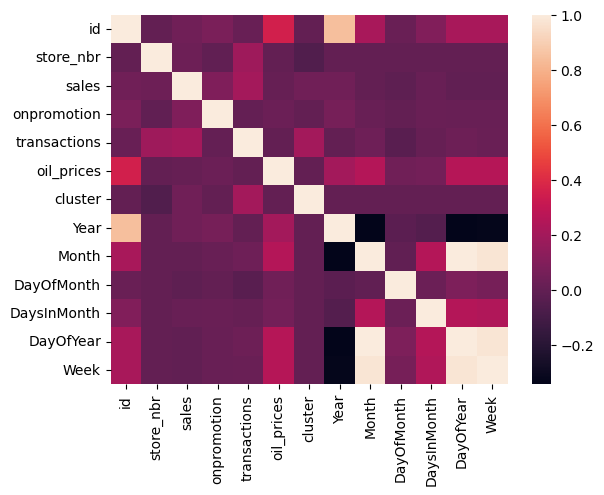

In [51]:
# Visualising the correlation with a heatmap

sns.heatmap(train_data.corr())

## HYPOTHESIS TESTING

Null Hypothesis:There is no stationariy in the dataset. 

Alternate Hypothesis: There is stationariy in the dataset

#### STATISTICAL TESTING

#### KPSS TEST

In [129]:
# Significant Value - 5%

stats,p,lags,critical_values = kpss(train_data['sales'], 'ct')
print(f'Test_Statistics: {stats}')
print(f'P-Value:{p}')
print(f'Critical Values:{critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test_Statistics: 1.0877836446716562
P-Value:0.01
Critical Values:{'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


### AUGMENTED DICKEY FULLER (ADF) TEST

In [53]:
# OUR SIGNIFICANT LEVEL IS 5%

#result = adfuller(train_data['sales'])
#print(f'Test Statistics:{result[0]}')
#print(f'p-value:{result[1]}')
#print(f'Critical Values:{result[4]}')

#if result[1] < 0.05:
    #print('There is no stationarity in the dataset')
#else:
    #print('There is stationarity in the dataset')

## DECOMPOSING THE SALES DATA SERIES TO MAKE IT STATIONARY

In [126]:
train_data['sales_diff'] = train_data['sales'] - train_data['sales'].shift(1)

In [130]:
train_data

id  store_nbr                      family   sales  \
date                                                                 
2013-01-01        0          1                  AUTOMOTIVE   0.000   
2013-01-01        1          1                   BABY CARE   0.000   
2013-01-01        2          1                      BEAUTY   0.000   
2013-01-01        3          1                   BEVERAGES   0.000   
2013-01-01        4          1                       BOOKS   0.000   
...             ...        ...                         ...     ...   
2014-08-13  1048570          3                     POULTRY 974.098   
2014-08-13  1048571          3              PREPARED FOODS 324.293   
2014-08-13  1048572          3                     PRODUCE  10.000   
2014-08-13  1048573          3  SCHOOL AND OFFICE SUPPLIES   0.000   
2014-08-13  1048574          3                     SEAFOOD  69.116   

            onpromotion  transactions holidays_type    locale locale_name  \
date                                                                        
2013-01-01            0           NaN       Holiday  National     Ecuador   
2013-01-01            0           NaN       Holiday  National     Ecuador   
2013-01-01            0           NaN       Holiday  National     Ecuador   
2013-01-01            0           NaN       Holiday  National     Ecuador   
2013-01-01            0           NaN       Holiday  National     Ecuador   
...                 ...           ...           ...       ...         ...   
2014-08-13            1      2991.000           NaN       NaN         NaN   
2014-08-13            0      2991.000           NaN       NaN         NaN   
2014-08-13            1      2991.000           NaN       NaN         NaN   
2014-08-13            0      2991.000           NaN       NaN         NaN   
2014-08-13            0      2991.000           NaN       NaN         NaN   

                   description  ...      state  store_type cluster  Year  \
date                            ...                                        
2013-01-01  Primer dia del ano  ...  Pichincha           D      13  2013   
2013-01-01  Primer dia del ano  ...  Pichincha           D      13  2013   
2013-01-01  Primer dia del ano  ...  Pichincha           D      13  2013   
2013-01-01  Primer dia del ano  ...  Pichincha           D      13  2013   
2013-01-01  Primer dia del ano  ...  Pichincha           D      13  2013   
...                        ...  ...        ...         ...     ...   ...   
2014-08-13                 NaN  ...  Pichincha           D       8  2014   
2014-08-13                 NaN  ...  Pichincha           D       8  2014   
2014-08-13                 NaN  ...  Pichincha           D       8  2014   
2014-08-13                 NaN  ...  Pichincha           D       8  2014   
2014-08-13                 NaN  ...  Pichincha           D       8  2014   

           Month  DayOfMonth  DaysInMonth  DayOfYear  Week  sales_diff  
date                                                                    
2013-01-01     1           1           31          1     1         NaN  
2013-01-01     1           1           31          1     1       0.000  
2013-01-01     1           1           31          1     1       0.000  
2013-01-01     1           1           31          1     1       0.000  
2013-01-01     1           1           31          1     1       0.000  
...          ...         ...          ...        ...   ...         ...  
2014-08-13     8          13           31        225    33     974.098  
2014-08-13     8          13           31        225    33    -649.805  
2014-08-13     8          13           31        225    33    -314.293  
2014-08-13     8          13           31        225    33     -10.000  
2014-08-13     8          13           31        225    33      69.116  

[1064613 rows x 23 columns]

In [133]:
# FILLING THE NAN VALUES IN SALES_DIFF COLUMN WITH '0'

train_data['sales_diff'].fillna(0,inplace=True)

## RETESTING WITH KPSS TO CHECK FOR STATIONARITY

In [132]:
# Significant Value - 5%

stats,p,lags,critical_values = kpss(train_data['sales_diff'], 'ct')
print(f'Test_Statistics: {stats}')
print(f'P-Value:{p}')
print(f'Critical Values:{critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test_Statistics: 0.00022805156648391463
P-Value:0.1
Critical Values:{'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is Stationary


THE DATA SERIES IS NOW STATIONARY AS THE VALUE IS LESS THAN OUR SIGNIFICANT VALUE OF 5%. THAT IS THE P-VALUE IS 0.1 (1%).

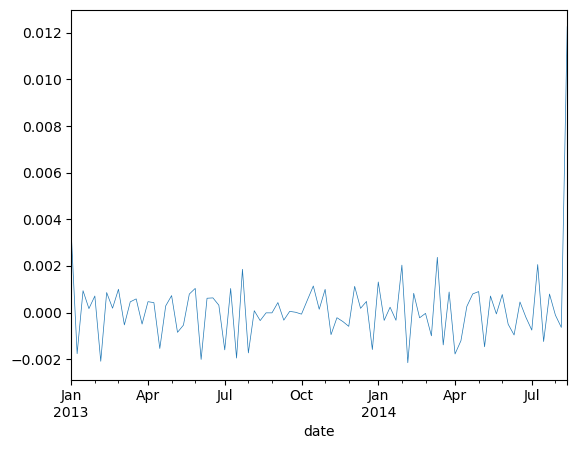

In [145]:
# SPECIFY THE COLUMNS TO INCLUDE

data_columns = ['sales_diff', 'transactions', 'onpromotion', 'oil_prices']

# Resample to weekly frequency, aggregating with mean

data_weekly_mean = train_data[data_columns].resample('w').mean()

data_weekly_mean.head()


# Visualising the data_weekly_mean calculated above

data_weekly_mean['sales_diff'].plot(linewidth=0.5);

The series is now stationary

## ANSWERING SOME OF THE ANALYTICAL QUESTIONS

1) Is the train dataset complete (has all the required dates)?

2) Which dates have the lowest and highest sales for each year?

3) Did the earthquake impact sales?

4) Are certain groups of stores selling more products? (Cluster, city, state, type)

5) Are sales affected by promotions, oil prices and holidays?

6) What analysis can we get from the date and its extractable features?

7) What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)



## 1. Is the train dataset complete (has all the required dates)?

In [54]:
train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [55]:
# CONVERTING THE DATE TO DATE TIME

train['date'] = pd.to_datetime(train['date'])

In [56]:
# DETERMINING THE MIN AND MAX TIME
train['date'].min(), train['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2014-08-13 00:00:00'))

In [57]:
# Extracting dates which are not in the train dataset

missing_dates=pd.date_range(start= '2013-01-01', end='2014-08-13').difference(train.date)

missing_dates

DatetimeIndex(['2013-12-25'], dtype='datetime64[ns]', freq=None)

from the above, the train dataset does not have all the required date. The missing date is '2013-12-25'.

### TREATING THE MISSING DATE

In [58]:
#to fix missing dates in the train dataset, we would import iterable product
#this will help us to loop over each item in the selected arguments 

#creating variables as arguments for the product() method

missing_dates
uniques_stores=train.store_nbr.unique()
unique_family=train.family.unique()

In [59]:
#we will replace the missing dates by pairing it with all the unique stores and families

replace_dates=list(product(missing_dates, uniques_stores,unique_family ))

In [60]:
#creating a dataframe for the replaced dates

replace_dates_df=pd.DataFrame(replace_dates, columns=['date', 'store_nbr', 'family'])

replace_dates_df.head()

date  store_nbr      family
0 2013-12-25          1  AUTOMOTIVE
1 2013-12-25          1   BABY CARE
2 2013-12-25          1      BEAUTY
3 2013-12-25          1   BEVERAGES
4 2013-12-25          1       BOOKS

In [61]:
#adding replaced dates to our train data
new_train=pd.concat([train, replace_dates_df], ignore_index=True)

new_train.head()

id       date  store_nbr      family  sales  onpromotion
0  0.0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1  1.0 2013-01-01          1   BABY CARE    0.0          0.0
2  2.0 2013-01-01          1      BEAUTY    0.0          0.0
3  3.0 2013-01-01          1   BEVERAGES    0.0          0.0
4  4.0 2013-01-01          1       BOOKS    0.0          0.0

In [62]:
missing_dates=pd.date_range(start= '2013-01-01', end='2014-08-13').difference(new_train.date)

missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Now,there is no more missing dates.

In [63]:
new_train.isnull().sum()

id             1782
date              0
store_nbr         0
family            0
sales          1782
onpromotion    1782
dtype: int64

In [64]:
#filling Nan values in sales and onpromotion column with 0

new_train.fillna(0,inplace=True)

new_train.isnull().sum()


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [65]:
#dropping id column since it's not relevant

new_train=new_train.drop('id', axis='columns')

new_train.head()

date  store_nbr      family  sales  onpromotion
0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1 2013-01-01          1   BABY CARE    0.0          0.0
2 2013-01-01          1      BEAUTY    0.0          0.0
3 2013-01-01          1   BEVERAGES    0.0          0.0
4 2013-01-01          1       BOOKS    0.0          0.0

## 2. Which dates have the lowest and highest sales for each year?

In [66]:
# Making a copy of the new_train and storing it as train2

train2 = new_train.copy()

train2['Year'] = train2['date'].dt.year

In [67]:
train2.head()

date  store_nbr      family  sales  onpromotion  Year
0 2013-01-01          1  AUTOMOTIVE    0.0          0.0  2013
1 2013-01-01          1   BABY CARE    0.0          0.0  2013
2 2013-01-01          1      BEAUTY    0.0          0.0  2013
3 2013-01-01          1   BEVERAGES    0.0          0.0  2013
4 2013-01-01          1       BOOKS    0.0          0.0  2013

In [68]:
# Calculating the aggregate Sales 

aggregate_sales = train2.groupby(['date']).agg(daily_sales=('sales', 'sum'), year=('Year', 'mean'))

aggregate_sales.head()

daily_sales    year
date                             
2013-01-01    2511.618999  2013.0
2013-01-02  496092.417944  2013.0
2013-01-03  361461.231124  2013.0
2013-01-04  354459.677093  2013.0
2013-01-05  477350.121229  2013.0

In [69]:

aggregate_sales['year'] = aggregate_sales['year'].astype(int).astype(str)

In [70]:
aggregate_sales.head()

daily_sales  year
date                           
2013-01-01    2511.618999  2013
2013-01-02  496092.417944  2013
2013-01-03  361461.231124  2013
2013-01-04  354459.677093  2013
2013-01-05  477350.121229  2013

In [71]:
# Creating a function that will calculate the min_max sales for each year 

def min_max_sales(aggregate):
    unique_years = aggregate['year'].unique().tolist()
    for year in unique_years:
        year_agg = aggregate.loc[str(year)]
        max_sale = year_agg['daily_sales'].max()
        min_sale = year_agg['daily_sales'].min()
        print(f'The maximum and minimum sales in {year} are ${max_sale:,.2f} and ${min_sale:,.2f} respectively')

In [72]:
min_max_sales(aggregate_sales)

The maximum and minimum sales in 2013 are $792,865.28 and $0.00 respectively
The maximum and minimum sales in 2014 are $949,618.79 and $8,602.07 respectively


## 3. Did the earthquake impact sales?

### A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

### Note: There is no 2016 in my dataset, so, we assume that the earthquake took place on April 16, 2014.

In [73]:
new_train.head()

date  store_nbr      family  sales  onpromotion
0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1 2013-01-01          1   BABY CARE    0.0          0.0
2 2013-01-01          1      BEAUTY    0.0          0.0
3 2013-01-01          1   BEVERAGES    0.0          0.0
4 2013-01-01          1       BOOKS    0.0          0.0

### Let's Calculate Sales Before the Earthquake

In [85]:
# Extracting two weeks sales before the earthquake

start_date='2014-04-01'

end_date='2014-04-15'

#setting date to datetime

new_train['date']=pd.to_datetime(new_train['date'])

# getting start and end date using mask function to select rows between dates

mask = (new_train['date']>=start_date) & (new_train['date']<=end_date)

start_end_df_b4=new_train.loc[mask]

start_end_df_b4.head()

date  store_nbr      family   sales  onpromotion
809028 2014-04-01          1  AUTOMOTIVE    10.0          0.0
809029 2014-04-01          1   BABY CARE     0.0          0.0
809030 2014-04-01          1      BEAUTY     3.0          0.0
809031 2014-04-01          1   BEVERAGES  1096.0          0.0
809032 2014-04-01          1       BOOKS     0.0          0.0

In [86]:
# Calculating Sales Before the Earthquake

sales_b4 = start_end_df_b4['sales'].sum()
print('Total sales before earthquake:', sales_b4)

Total sales before earthquake: 6717960.9846593


In [88]:
#aggregate of sales before 

aggregate_sales_b4=start_end_df_b4.groupby(['date'])['sales'].sum()

aggregate_sales_b4

date
2014-04-01    485079.887001
2014-04-02    463917.316107
2014-04-03    388867.961418
2014-04-04    422578.745073
2014-04-05    617680.194045
2014-04-06    631888.250898
2014-04-07    426091.104018
2014-04-08    376663.272105
2014-04-09    375309.082012
2014-04-10    334052.757126
2014-04-11    379646.845927
2014-04-12    529919.922964
2014-04-13    540190.281942
2014-04-14    381386.309033
2014-04-15    364689.054991
Name: sales, dtype: float64

### Let's Calculate Sales after the Earthquake

In [90]:
#getting two weeks sales after the earthquake
start_date='2014-04-17'
end_date='2014-04-30'

#setting date to datetime
#new_train_data['date']=pd.to_datetime(new_train_data_df['date'])

#getting start and end date using mask function to select rows between dates

mask= (new_train['date']>=start_date) & (new_train['date']<=end_date)

start_end_df_after=new_train.loc[mask]

start_end_df_after.head()

date  store_nbr      family  sales  onpromotion
837540 2014-04-17          1  AUTOMOTIVE    1.0          0.0
837541 2014-04-17          1   BABY CARE    0.0          0.0
837542 2014-04-17          1      BEAUTY    1.0          0.0
837543 2014-04-17          1   BEVERAGES  972.0          0.0
837544 2014-04-17          1       BOOKS    0.0          0.0

In [91]:
# Getting the sales after the earthquake

sales_after= start_end_df_after['sales'].sum()
print('Total sales after earthquake:', sales_after)

Total sales after earthquake: 5731932.987505101


In [92]:
#aggregate of sales before 

aggregate_sales_after=start_end_df_after.groupby(['date'])['sales'].sum()
aggregate_sales_after

date
2014-04-17    397464.842904
2014-04-18    394392.184115
2014-04-19    496904.749136
2014-04-20    520126.398039
2014-04-21    398677.396998
2014-04-22    370552.249018
2014-04-23    372232.595049
2014-04-24    320875.477858
2014-04-25    357173.708433
2014-04-26    497334.735036
2014-04-27    560508.420995
2014-04-28    362271.916981
2014-04-29    326338.348031
2014-04-30    357079.964912
Name: sales, dtype: float64

In [95]:
# Visualising the Impact on sales using subplots

fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Scatter(
    x=aggregate_sales_b4.reset_index()['date'].astype('str').values.tolist(),
    y=aggregate_sales_b4.reset_index()['sales'].values.tolist(), name='sales_before'
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=aggregate_sales_after.reset_index()['date'].astype('str').values.tolist(),
    y=aggregate_sales_after.reset_index()['sales'].values.tolist(),  name='sales_after'
), row=1, col=1)

fig.update_layout(height=900, width=1000, title_text="Impact of earthquake on sales before and after")
fig.show()

from the above subplots, it is very obvious that they was a negative impact on sales after the earthquake. There was a drop in sales.

### 4) Are certain groups of stores selling more products? (Cluster, city, state, type)

In [102]:
# selecting the relevant columns fron from the train_data

store_sales = train_data[['store_nbr','family','sales','onpromotion','city','state','store_type','cluster']]
                         
store_sales

store_nbr                      family    sales  onpromotion  \
date                                                                      
2013-01-01          1                  AUTOMOTIVE    0.000            0   
2013-01-01          1                   BABY CARE    0.000            0   
2013-01-01          1                      BEAUTY    0.000            0   
2013-01-01          1                   BEVERAGES    0.000            0   
2013-01-01          1                       BOOKS    0.000            0   
...               ...                         ...      ...          ...   
2014-08-13          3                     POULTRY  974.098            1   
2014-08-13          3              PREPARED FOODS  324.293            0   
2014-08-13          3                     PRODUCE   10.000            1   
2014-08-13          3  SCHOOL AND OFFICE SUPPLIES    0.000            0   
2014-08-13          3                     SEAFOOD   69.116            0   

             city      state store_type  cluster  
date                                              
2013-01-01  Quito  Pichincha          D       13  
2013-01-01  Quito  Pichincha          D       13  
2013-01-01  Quito  Pichincha          D       13  
2013-01-01  Quito  Pichincha          D       13  
2013-01-01  Quito  Pichincha          D       13  
...           ...        ...        ...      ...  
2014-08-13  Quito  Pichincha          D        8  
2014-08-13  Quito  Pichincha          D        8  
2014-08-13  Quito  Pichincha          D        8  
2014-08-13  Quito  Pichincha          D        8  
2014-08-13  Quito  Pichincha          D        8  

[1064613 rows x 8 columns]

In [103]:
# Declaring a function that will list the unique values in all the columns of the store_sales data above

def unique_values(data):
    for column in data.columns:
        print(f'The unique values in {column} column are: {", ".join(data[column].astype(str).unique().tolist())}')
        print('\n')
        print('-' * 120)

In [104]:
unique_values(store_sales)

The unique values in store_nbr column are: 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 6, 7, 8, 9


------------------------------------------------------------------------------------------------------------------------
The unique values in family column are: AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOOKS, BREAD/BAKERY, CELEBRATION, CLEANING, DAIRY, DELI, EGGS, FROZEN FOODS, GROCERY I, GROCERY II, HARDWARE, HOME AND KITCHEN I, HOME AND KITCHEN II, HOME APPLIANCES, HOME CARE, LADIESWEAR, LAWN AND GARDEN, LINGERIE, LIQUOR,WINE,BEER, MAGAZINES, MEATS, PERSONAL CARE, PET SUPPLIES, PLAYERS AND ELECTRONICS, POULTRY, PREPARED FOODS, PRODUCE, SCHOOL AND OFFICE SUPPLIES, SEAFOOD


------------------------------------------------------------------------------------------------------------------------
The unique values in sales column are: 0.0, 2

The unique values in onpromotion column are: 0, 3, 5, 1, 56, 20, 19, 2, 4, 18, 17, 12, 6, 7, 10, 9, 50, 8, 16, 42, 51, 13, 15, 47, 21, 40, 37, 54, 24, 58, 22, 59, 11, 45, 25, 55, 26, 43, 35, 14, 28, 46, 36, 32, 53, 57, 27, 39, 41, 30, 29, 49, 23, 48, 44, 38, 31, 52, 33, 34, 61, 60, 116, 86, 73, 113, 102, 68, 104, 93, 70, 92, 121, 72, 178, 174, 161, 118, 105, 172, 163, 167, 142, 154, 133, 180, 181, 173, 165, 168, 186, 140, 149, 145, 169, 188, 62, 84, 111, 65, 107, 63, 101, 87, 125, 94, 114, 171, 153, 170, 166, 141, 155, 179, 192, 131, 147, 151, 189, 79, 74, 110, 64, 67, 99, 123, 157, 117, 150, 182, 162, 160, 194, 135, 190, 69, 108, 89, 126, 156, 103, 146, 132, 177, 164, 176, 112, 75, 109, 91, 128, 175, 187, 148, 137, 184, 196, 144, 158


------------------------------------------------------------------------------------------------------------------------
The unique values in city column are: Quito, Cayambe, Latacunga, Riobamba, Ibarra, Santo Domingo, Guaranda, Puyo, Ambato, Guayaquil,

In [105]:
# getting the City aggregate sales

pd.set_option('display.float_format', lambda x: '%.3f' % x)
city_aggregate = store_sales.groupby(['city'])['sales'].mean().sort_values(ascending=False).reset_index()
city_aggregate.head()

city   sales
0  Cayambe 412.144
1    Quito 383.875
2   Ambato 283.834
3     Loja 265.776
4    Daule 229.395

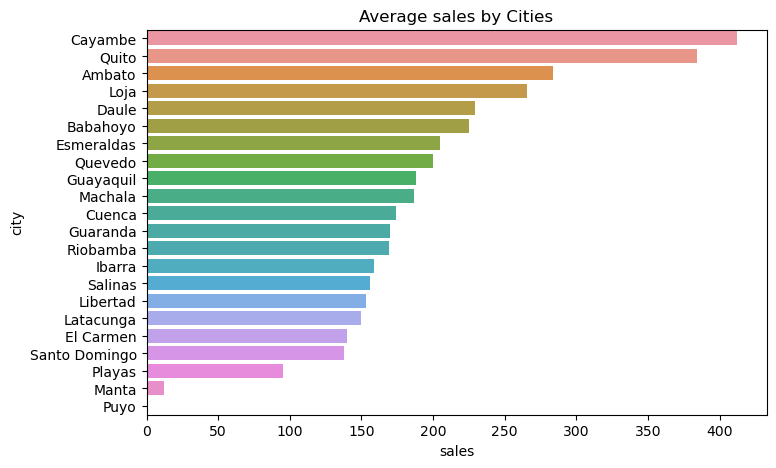

In [106]:
# Visiualizing the Average Sales by Cities using barplot

plt.figure(figsize=(8,5))
sns.barplot(x='sales', y='city', data=city_aggregate, orient='h')
plt.title('Average sales by Cities')
plt.show()

CAYAMBE CITY HAS THE HIGHEST SALES

In [107]:
# Getting the Clustter Sales

pd.set_option('display.float_format', lambda x: '%.3f' % x)
cluster_aggregate = store_sales.groupby(['cluster'])['sales'].mean().sort_values(ascending=False).reset_index()
cluster_aggregate['cluster'] = cluster_aggregate['cluster'].astype(str)
cluster_aggregate.head()

cluster   sales
0       5 798.077
1      14 527.857
2      17 448.999
3       8 444.642
4      11 373.788

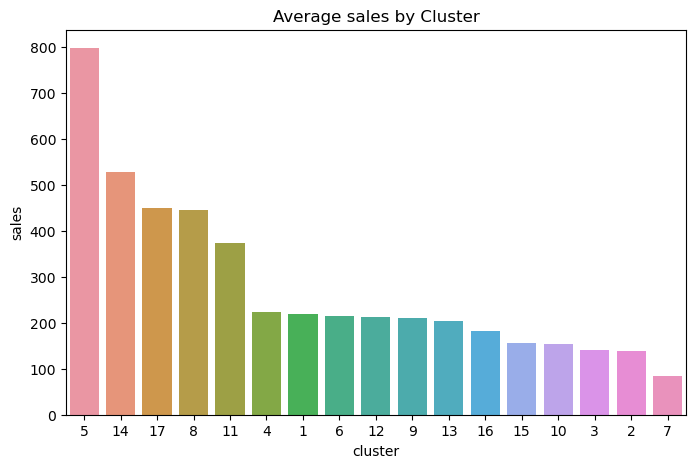

In [108]:
# Visiualizing the Average Clustter sales

plt.figure(figsize=(8,5))
sns.barplot(x='cluster', y='sales', data=cluster_aggregate)
plt.title('Average sales by Cluster')
plt.show()

CLUSTTER 5 HAS THE HIGHEST SALES

In [109]:
# Getting the Sales By State

pd.set_option('display.float_format', lambda x: '%.3f' % x)
state_aggregate = store_sales.groupby(['state'])['sales'].mean().sort_values(ascending=False).reset_index()
state_aggregate.head()

state   sales
0   Pichincha 385.364
1  Tungurahua 283.834
2        Loja 265.776
3    Los Rios 212.710
4  Esmeraldas 204.528

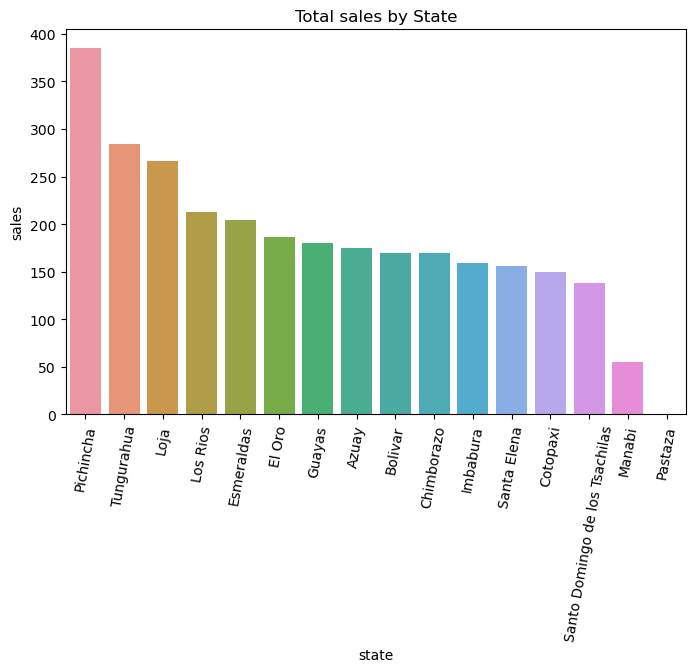

In [110]:
# Visiualizing the Total Sales by State

plt.figure(figsize=(8,5))
sns.barplot(x='state', y='sales', data=state_aggregate)
plt.title('Total sales by State')
plt.xticks(rotation=80)
plt.show()

PICHINCHA STATE HAS THE HIGHEST SALES

In [112]:
# Getting the Sales by the store_type

pd.set_option('display.float_format', lambda x: '%.3f' % x)
type_aggregate = store_sales.groupby(['store_type'])['sales'].mean().sort_values(ascending=False).reset_index()
type_aggregate.head()

store_type   sales
0          A 497.763
1          D 238.888
2          B 211.420
3          E 143.486
4          C 143.430

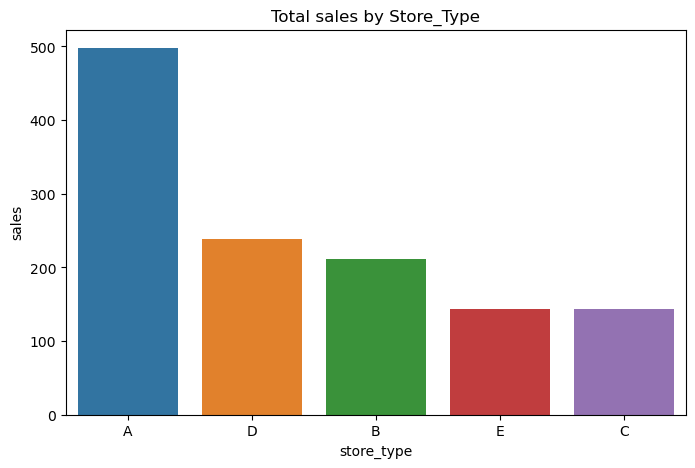

In [114]:
# Visiualizing the total sales by Store_type

plt.figure(figsize=(8,5))
sns.barplot(x='store_type', y='sales', data=type_aggregate)
plt.title('Total sales by Store_Type')
plt.show()

STORE_TYPE A HAS THE HIGHEST SALES

## 5) Are sales affected by promotions, oil prices and holidays?

## sales vs oil price

In [116]:
# SELECTING THE RELEVANT COLUMNS FROM THE TRAIN_DATA

oil_train = train_data[['oil_prices','sales']]

oil_train

oil_prices   sales
date                          
2013-01-01      67.714   0.000
2013-01-01      67.714   0.000
2013-01-01      67.714   0.000
2013-01-01      67.714   0.000
2013-01-01      67.714   0.000
...                ...     ...
2014-08-13      97.570 974.098
2014-08-13      97.570 324.293
2014-08-13      97.570  10.000
2014-08-13      97.570   0.000
2014-08-13      97.570  69.116

[1064613 rows x 2 columns]

In [117]:
# getting the oil_price vs sales

oil_price_group = oil_train.groupby(['oil_prices'], as_index=False)['sales'].mean()
oil_price_group.head()

oil_prices   sales
0      67.714 191.740
1      86.650 187.986
2      87.830 158.207
3      88.040 174.853
4      88.730 187.111

Text(0, 0.5, 'Sales')

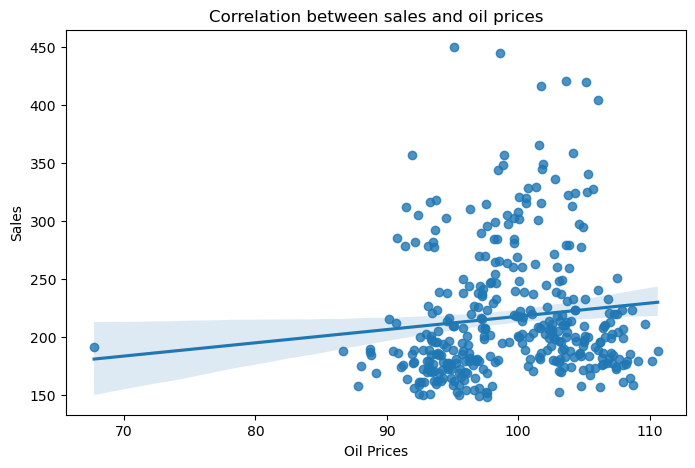

In [118]:
# Visiualizing the oil_price against sales

plt.figure(figsize=(8, 5))
sns.regplot(data=oil_price_group, x='oil_prices', y='sales')
plt.title('Correlation between sales and oil prices')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')

 The Sales decreases as the oil price increases

## sales vs onpromotion

In [119]:
# selecting the relevant columns

onpromo_df = train_data[['sales', 'onpromotion']]
onpromo_df.head()

sales  onpromotion
date                          
2013-01-01  0.000            0
2013-01-01  0.000            0
2013-01-01  0.000            0
2013-01-01  0.000            0
2013-01-01  0.000            0

In [120]:
# getting sales vs onpromotion data

onpromo_group = onpromo_df.groupby(['onpromotion'], as_index=False)['sales'].mean()
onpromo_group.head()

onpromotion    sales
0            0  226.288
1            1  676.396
2            2 1320.002
3            3 1864.444
4            4 2342.303

Text(0, 0.5, 'Sales')

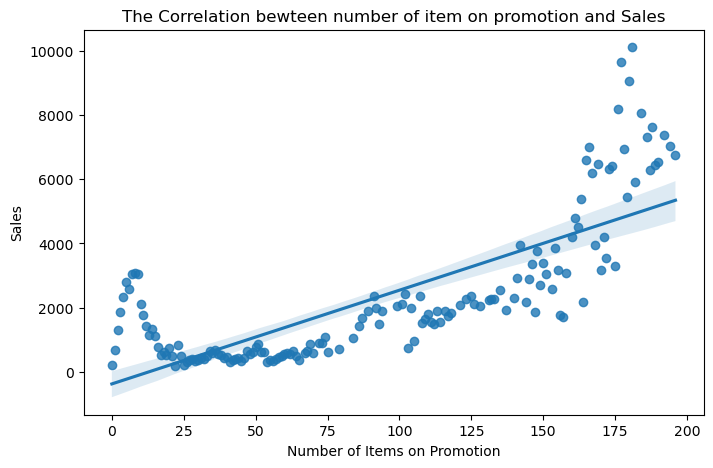

In [121]:
# Visiualizing the Sales vs onpromotion relationship

plt.figure(figsize=(8, 5))
sns.regplot(data=onpromo_group, x='onpromotion', y='sales')
plt.title('The Correlation bewteen number of item on promotion and Sales')
plt.xlabel('Number of Items on Promotion')
plt.ylabel('Sales')

As the items on promotion increases, the sales also increases.

## Sales vs Holidays

In [124]:
# selecting the relevant columns

holidays_sales = train_data[['store_nbr','family','sales','onpromotion','holidays_type','transferred']]

holidays_sales

store_nbr                      family   sales  onpromotion  \
date                                                                     
2013-01-01          1                  AUTOMOTIVE   0.000            0   
2013-01-01          1                   BABY CARE   0.000            0   
2013-01-01          1                      BEAUTY   0.000            0   
2013-01-01          1                   BEVERAGES   0.000            0   
2013-01-01          1                       BOOKS   0.000            0   
...               ...                         ...     ...          ...   
2014-08-13          3                     POULTRY 974.098            1   
2014-08-13          3              PREPARED FOODS 324.293            0   
2014-08-13          3                     PRODUCE  10.000            1   
2014-08-13          3  SCHOOL AND OFFICE SUPPLIES   0.000            0   
2014-08-13          3                     SEAFOOD  69.116            0   

           holidays_type transferred  
date                                  
2013-01-01       Holiday       False  
2013-01-01       Holiday       False  
2013-01-01       Holiday       False  
2013-01-01       Holiday       False  
2013-01-01       Holiday       False  
...                  ...         ...  
2014-08-13           NaN         NaN  
2014-08-13           NaN         NaN  
2014-08-13           NaN         NaN  
2014-08-13           NaN         NaN  
2014-08-13           NaN         NaN  

[1064613 rows x 6 columns]

In [125]:
holidays_sales['holidays_type'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer'],
      dtype=object)

*Sales are affected by promotion, oil and holidays.

*The increase in oil prices results in the decrease of sales.

*The more the number of items on a promotion in a store the higher the sales

## FEATURES ENCODING

In [134]:
train_data.head()

id  store_nbr      family  sales  onpromotion  transactions  \
date                                                                      
2013-01-01   0          1  AUTOMOTIVE  0.000            0           NaN   
2013-01-01   1          1   BABY CARE  0.000            0           NaN   
2013-01-01   2          1      BEAUTY  0.000            0           NaN   
2013-01-01   3          1   BEVERAGES  0.000            0           NaN   
2013-01-01   4          1       BOOKS  0.000            0           NaN   

           holidays_type    locale locale_name         description  ...  \
date                                                                ...   
2013-01-01       Holiday  National     Ecuador  Primer dia del ano  ...   
2013-01-01       Holiday  National     Ecuador  Primer dia del ano  ...   
2013-01-01       Holiday  National     Ecuador  Primer dia del ano  ...   
2013-01-01       Holiday  National     Ecuador  Primer dia del ano  ...   
2013-01-01       Holiday  National     Ecuador  Primer dia del ano  ...   

                state  store_type cluster  Year Month  DayOfMonth  \
date                                                                
2013-01-01  Pichincha           D      13  2013     1           1   
2013-01-01  Pichincha           D      13  2013     1           1   
2013-01-01  Pichincha           D      13  2013     1           1   
2013-01-01  Pichincha           D      13  2013     1           1   
2013-01-01  Pichincha           D      13  2013     1           1   

            DaysInMonth  DayOfYear  Week  sales_diff  
date                                                  
2013-01-01           31          1     1       0.000  
2013-01-01           31          1     1       0.000  
2013-01-01           31          1     1       0.000  
2013-01-01           31          1     1       0.000  
2013-01-01           31          1     1       0.000  

[5 rows x 23 columns]

In [221]:
# Dropping the Sales column and rename the sales_diff as the new Sales column

train_data = train_data.drop(columns='sales', axis=1)

# Dropping 'id' column as it not relevant to the work

train_data = train_data.drop(columns='id', axis=1)

# Renaming the sales_diff column to Sales

train_data = train_data.rename(columns = {'sales_diff': 'Sales'})

In [222]:
train_data.head()

store_nbr      family  onpromotion  transactions holidays_type  \
date                                                                         
2013-01-01          1  AUTOMOTIVE            0       770.000       Holiday   
2013-01-01          1   BABY CARE            0       770.000       Holiday   
2013-01-01          1      BEAUTY            0       770.000       Holiday   
2013-01-01          1   BEVERAGES            0       770.000       Holiday   
2013-01-01          1       BOOKS            0       770.000       Holiday   

              locale locale_name         description  transferred  oil_prices  \
date                                                                            
2013-01-01  National     Ecuador  Primer dia del ano        False      67.714   
2013-01-01  National     Ecuador  Primer dia del ano        False      67.714   
2013-01-01  National     Ecuador  Primer dia del ano        False      67.714   
2013-01-01  National     Ecuador  Primer dia del ano        False      67.714   
2013-01-01  National     Ecuador  Primer dia del ano        False      67.714   

            ...      state store_type cluster  Year  Month  DayOfMonth  \
date        ...                                                          
2013-01-01  ...  Pichincha          D      13  2013      1           1   
2013-01-01  ...  Pichincha          D      13  2013      1           1   
2013-01-01  ...  Pichincha          D      13  2013      1           1   
2013-01-01  ...  Pichincha          D      13  2013      1           1   
2013-01-01  ...  Pichincha          D      13  2013      1           1   

            DaysInMonth  DayOfYear  Week  Sales  
date                                             
2013-01-01           31          1     1  0.000  
2013-01-01           31          1     1  0.000  
2013-01-01           31          1     1  0.000  
2013-01-01           31          1     1  0.000  
2013-01-01           31          1     1  0.000  

[5 rows x 21 columns]

In [223]:
train_data.isna().sum()

store_nbr        0
family           0
onpromotion      0
transactions     0
holidays_type    0
locale           0
locale_name      0
description      0
transferred      0
oil_prices       0
city             0
state            0
store_type       0
cluster          0
Year             0
Month            0
DayOfMonth       0
DaysInMonth      0
DayOfYear        0
Week             0
Sales            0
dtype: int64

## IMPUTTING THE MISSING VALUES

In [224]:
# Using forward abd Backward fill

train_data = train_data.ffill().bfill()

train_data.isnull().sum()

store_nbr        0
family           0
onpromotion      0
transactions     0
holidays_type    0
locale           0
locale_name      0
description      0
transferred      0
oil_prices       0
city             0
state            0
store_type       0
cluster          0
Year             0
Month            0
DayOfMonth       0
DaysInMonth      0
DayOfYear        0
Week             0
Sales            0
dtype: int64

In [225]:
# getting the target variable 'y_train' and the dependent variable 'x_train'

y_train = train_data['Sales'].copy()

x_train = train_data.drop(columns=['Sales'])

In [235]:
x_train.head()

store_nbr      family  onpromotion  transactions holidays_type  \
date                                                                         
2013-01-01          1  AUTOMOTIVE            0       770.000       Holiday   
2013-01-01          1   BABY CARE            0       770.000       Holiday   
2013-01-01          1      BEAUTY            0       770.000       Holiday   
2013-01-01          1   BEVERAGES            0       770.000       Holiday   
2013-01-01          1       BOOKS            0       770.000       Holiday   

              locale locale_name         description  transferred  oil_prices  \
date                                                                            
2013-01-01  National     Ecuador  Primer dia del ano        False      67.714   
2013-01-01  National     Ecuador  Primer dia del ano        False      67.714   
2013-01-01  National     Ecuador  Primer dia del ano        False      67.714   
2013-01-01  National     Ecuador  Primer dia del ano        False      67.714   
2013-01-01  National     Ecuador  Primer dia del ano        False      67.714   

             city      state store_type  cluster  Year  Month  DayOfMonth  \
date                                                                        
2013-01-01  Quito  Pichincha          D       13  2013      1           1   
2013-01-01  Quito  Pichincha          D       13  2013      1           1   
2013-01-01  Quito  Pichincha          D       13  2013      1           1   
2013-01-01  Quito  Pichincha          D       13  2013      1           1   
2013-01-01  Quito  Pichincha          D       13  2013      1           1   

            DaysInMonth  DayOfYear  Week  
date                                      
2013-01-01           31          1     1  
2013-01-01           31          1     1  
2013-01-01           31          1     1  
2013-01-01           31          1     1  
2013-01-01           31          1     1

In [237]:
y_train.head()

date
2013-01-01   0.000
2013-01-01   0.000
2013-01-01   0.000
2013-01-01   0.000
2013-01-01   0.000
Name: Sales, dtype: float64

In [226]:
# Getting the numerical and categorical variables

num_cols = x_train.select_dtypes(exclude='object').columns

cat_cols = x_train.select_dtypes(include='object').columns

## Features Scaling & Encoding

In [227]:
cat_encoder = OneHotEncoder(sparse=False)

num_scaler = StandardScaler()

# Apply SimpleImputer

num_imputer = SimpleImputer(strategy = 'mean').set_output(transform = 'pandas')

cat_imputer = SimpleImputer(strategy = 'most_frequent').set_output(transform = 'pandas')


In [228]:
# Feature pipeline

num_pipe = Pipeline(steps = [('num_imputer', num_imputer), ('scaler', num_scaler)])

cat_pipe = Pipeline(steps = [('cat_imputer', cat_imputer), ('encoder', cat_encoder)])

In [229]:
# End2End_pipeline Features preprocessor 

preprocessor = ColumnTransformer([("StandardScaler", num_pipe, num_cols),
                                  ("OneHotEncoder", cat_pipe, cat_cols),])
preprocessor.set_output(transform='pandas')

ColumnTransformer(transformers=[('StandardScaler',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['store_nbr', 'onpromotion', 'transactions', 'transferred', 'oil_prices',
       'cluster', 'Year', 'Month', 'DayOfMonth', 'DaysInMonth', 'DayOfYear',
       'Week'],
      dtype='object')),
                                ('OneHotEncoder',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(sparse=False))]),
                                 Index(['family', 'holidays_type', 'locale', 'locale_name', 'description',
       'city', 'state', 'store_type'],
      dtype='object'))])

In [230]:
rg = Pipeline([('preprocessor',preprocessor), ('model', None)]).set_output(transform = 'pandas')

In [231]:
# Training x_train with the preprocessor

x_trained = rg.fit_transform(x_train)

In [232]:
x_trained.head()

StandardScaler__store_nbr  StandardScaler__onpromotion  \
date                                                                 
2013-01-01                     -1.700                       -0.049   
2013-01-01                     -1.700                       -0.049   
2013-01-01                     -1.700                       -0.049   
2013-01-01                     -1.700                       -0.049   
2013-01-01                     -1.700                       -0.049   

            StandardScaler__transactions  StandardScaler__transferred  \
date                                                                    
2013-01-01                        -1.023                       -0.058   
2013-01-01                        -1.023                       -0.058   
2013-01-01                        -1.023                       -0.058   
2013-01-01                        -1.023                       -0.058   
2013-01-01                        -1.023                       -0.058   

            StandardScaler__oil_prices  StandardScaler__cluster  \
date                                                              
2013-01-01                      -4.005                    0.972   
2013-01-01                      -4.005                    0.972   
2013-01-01                      -4.005                    0.972   
2013-01-01                      -4.005                    0.972   
2013-01-01                      -4.005                    0.972   

            StandardScaler__Year  StandardScaler__Month  \
date                                                      
2013-01-01                -0.787                 -1.458   
2013-01-01                -0.787                 -1.458   
2013-01-01                -0.787                 -1.458   
2013-01-01                -0.787                 -1.458   
2013-01-01                -0.787                 -1.458   

            StandardScaler__DayOfMonth  StandardScaler__DaysInMonth  ...  \
date                                                                 ...   
2013-01-01                      -1.649                        0.659  ...   
2013-01-01                      -1.649                        0.659  ...   
2013-01-01                      -1.649                        0.659  ...   
2013-01-01                      -1.649                        0.659  ...   
2013-01-01                      -1.649                        0.659  ...   

            OneHotEncoder__state_Pastaza  OneHotEncoder__state_Pichincha  \
date                                                                       
2013-01-01                         0.000                           1.000   
2013-01-01                         0.000                           1.000   
2013-01-01                         0.000                           1.000   
2013-01-01                         0.000                           1.000   
2013-01-01                         0.000                           1.000   

            OneHotEncoder__state_Santa Elena  \
date                                           
2013-01-01                             0.000   
2013-01-01                             0.000   
2013-01-01                             0.000   
2013-01-01                             0.000   
2013-01-01                             0.000   

            OneHotEncoder__state_Santo Domingo de los Tsachilas  \
date                                                              
2013-01-01                                              0.000     
2013-01-01                                              0.000     
2013-01-01                                              0.000     
2013-01-01                                              0.000     
2013-01-01                                              0.000     

            OneHotEncoder__state_Tungurahua  OneHotEncoder__store_type_A  \
date                                                                       
2013-01-01                            0.000                        0.000   
2013-01-01              

## MACHINE LEARNING MODELING

### MODEL  1- LINEAR REGRESSION

In [219]:
lin_reg = Pipeline([('preprocessor',preprocessor), ('model', LinearRegression())]).set_output(transform = 'pandas')

lin_reg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['id', 'store_nbr', 'onpromotion', 'transactions', 'transferred',
       'oil_prices', 'cluster', 'Year', 'Month', 'DayOfMonth', 'DaysInMonth',
       'DayOfYear', 'Week'],
      dtype='object')),
                                                 ('OneHotEncoder',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  Index(['family', 'holidays_type', 'locale', 'locale_name', 'description',
       'city', 'state', 'store_type'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [234]:
# fitting the model with .fit method

lin_reg.fit(x_train, y_train)

ValueError: A given column is not a column of the dataframe